

Getting data for EOSBTC, interval 5m
Data for EOSBTC, interval 5m already exists...

Processing data for EOSBTC


Getting data for EOSBTC, interval 15m
Data for EOSBTC, interval 15m already exists...

Processing data for EOSBTC


Getting data for EOSBTC, interval 30m
Data for EOSBTC, interval 30m already exists...

Processing data for EOSBTC


Getting data for EOSBTC, interval 1h
Data for EOSBTC, interval 1h already exists...

Processing data for EOSBTC


Getting data for EOSBTC, interval 4h
Data for EOSBTC, interval 4h already exists...

Processing data for EOSBTC


Getting data for EOSBTC, interval 1d
Data for EOSBTC, interval 1d already exists...

Processing data for EOSBTC


Getting data for TRXBTC, interval 5m
Data for TRXBTC, interval 5m already exists...

Processing data for TRXBTC


Getting data for TRXBTC, interval 15m
Data for TRXBTC, interval 15m already exists...

Processing data for TRXBTC


Getting data for TRXBTC, interval 30m
Data for TRXBTC, interval 30m already exis

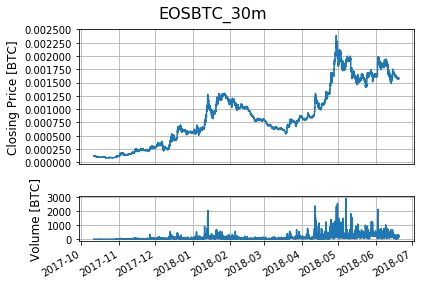

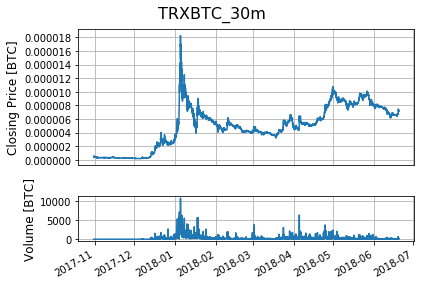

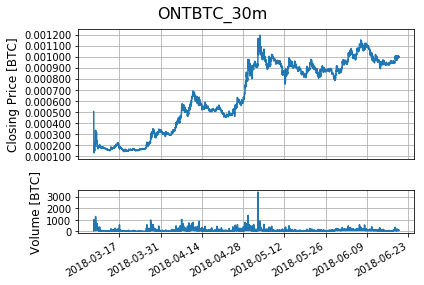

In [3]:
%matplotlib inline

import json
from datetime import datetime
from os import path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import requests

# Binance API url
root_binance_url = 'https://api.binance.com/api/v1/klines'
symbol_url = '?symbol='
interval_url = '&interval='
start_time_url = '&startTime='
end_time_url = '&endTime='
# limit is max 500 records, max 1200 requests/minute

symbols = ['EOSBTC', 'TRXBTC', 'ONTBTC']
# intervals: 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, ...
intervals = ['5m', '15m', '30m', '1h', '4h', '1d']
end_date_time = '20.06.2018 00:00:00'


def get_data(symbol, interval):
    # check is data file exists
    fname = 'binance_' + symbol + '_' + interval + '.json'
    if not path.isfile(fname):
        # from first available timestamp
        url = root_binance_url + symbol_url + symbol + interval_url + interval + start_time_url + '0'
        data = json.loads(requests.get(url).text)

        # new start time is the previous end timestamp, 500 is the limit/max
        start_time = data[-1][0]
        end_time = convert_date(end_date_time, True)
        while start_time < end_time:
            url = root_binance_url + symbol_url + symbol + interval_url + interval + start_time_url + str(start_time)
            data_new = json.loads(requests.get(url).text)
            # omit the first element as it is equal to the last on the previous list
            data = data + data_new[1:]
            start_time = data[-1][0]

        # save it to file
        with open(fname, 'w') as f:
            json.dump(data, f, sort_keys=True, indent=4, ensure_ascii=False)
    else:
        print('Data for {}, interval {} already exists...'.format(symbol, interval))


def convert_date(val, to_timestamp):
    if to_timestamp:
        dt = datetime.strptime(val, '%d.%m.%Y %H:%M:%S')
        millis_time = dt.timestamp() * 1000
        return int(millis_time)
    else:
        # time units are milliseconds
        date_col = pd.to_datetime(val, unit='ms')
        return date_col


def prepare_data(fname):
    df = pd.read_json(fname)

    # remove any rows with null values
    df = df.dropna()

    # columns [Open Time, Open, High, Low, Close, Volume, Close Time, Quote Asset Volume, + 4]
    df.drop(df.columns[8:], axis=1, inplace=True)
    df.drop(df.columns[5:7], axis=1, inplace=True)
    # Quote Asset Volume is volume in base currency = BTC
    col_names = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.columns = col_names

    # remove rows after end time
    end_time = convert_date(end_date_time, True)
    df = df[df['Open Time'] <= end_time]

    # sort by descending date, so that last point presents 15th June 2018
    df = df.sort_values(by='Open Time')

    # calc volatility
    df = df.assign(Volatility=lambda x: (x['High'] - x['Low']) / x['Open'])

    # Open Time, Close price, Volume and Volatility are the only columns needed for next step - TA calculation
    df.drop(df.columns[1:4], axis=1, inplace=True)

    return df


def plot_data(data, tag):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(tag, fontsize=16)

    date_col = convert_date(data['Open Time'], False)
    ax1.plot(date_col, data['Close'])
    ax1.grid(True)
    ax1.set_ylabel('Closing Price [BTC]', fontsize=12)
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax1.locator_params(axis='y', nbins=12)
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))

    ax2.plot(date_col, data['Volume'])
    ax2.grid(True)
    ax2.set_ylabel('Volume [BTC]', fontsize=12)
    ax2.locator_params(axis='y', nbins=4)

    fig.autofmt_xdate()
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.show()


coin_data = []
for sym in symbols:
    coin = []
    for t in intervals:
        print('\n\nGetting data for {}, interval {}'.format(sym, t))
        get_data(sym, t)

        print('\nProcessing data for {}'.format(sym))
        filename = 'binance_' + sym + '_' + t + '.json'
        coin.append(prepare_data(filename))
    coin_data.append(coin)

plot_data(coin_data[0][2], '{}_{}'.format(symbols[0], intervals[2]))
plot_data(coin_data[1][2], '{}_{}'.format(symbols[1], intervals[2]))
plot_data(coin_data[2][2], '{}_{}'.format(symbols[2], intervals[2]))
